<a href="https://colab.research.google.com/github/howsam/Building-a-ChatGPT-like-Model-from-Scratch/blob/main/2-2_Token-Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  <font color='#FFE15D'><b>💎 Token Embeddings</b></font>

# 🔴 **Environment Setup**

## 🟠 `pip`

In [ ]:
!pip install datasets

In [ ]:
!pip install gensim

⚠ Installation is complete! Please restart the runtime for the changes to take effect. You can do this by clicking **'Runtime' > 'Restart runtime'**.

## 🟠 Change the font size of the output cells

In [ ]:
print('Salam Howsam!')

Salam Howsam!


In [ ]:
from IPython.display import HTML
shell = get_ipython()

def adjust_font_size():
  display(HTML('''<style>
    body {
      font-size: 24px;
    }
  '''))

if adjust_font_size not in shell.events.callbacks['pre_execute']:
  shell.events.register('pre_execute', adjust_font_size)

In [ ]:
print('Salam Howsam!')

Salam Howsam!


# 🔴 **Import**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import TensorDataset, random_split, DataLoader
import torch.nn as nn
from torch import optim

from datasets import load_dataset
from tokenizers import Tokenizer

# 🔴 **TinyStories Dataset**

In [ ]:
dataset = load_dataset("roneneldan/TinyStories")
dataset

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 2119719
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 21990
    })
})

In [ ]:
# Number of samples to tokenize
n = 10000  # You can change this to any number

# Extract the first `n` samples
text_samples = dataset["train"][:n]["text"]

In [ ]:
text_samples

['One day, a little girl named Lily found a needle in her room. She knew it was difficult to play with it because it was sharp. Lily wanted to share the needle with her mom, so she could sew a button on her shirt.\n\nLily went to her mom and said, "Mom, I found this needle. Can you share it with me and sew my shirt?" Her mom smiled and said, "Yes, Lily, we can share the needle and fix your shirt."\n\nTogether, they shared the needle and sewed the button on Lily\'s shirt. It was not difficult for them because they were sharing and helping each other. After they finished, Lily thanked her mom for sharing the needle and fixing her shirt. They both felt happy because they had shared and worked together.',
 'Once upon a time, there was a little car named Beep. Beep loved to go fast and play in the sun. Beep was a healthy car because he always had good fuel. Good fuel made Beep happy and strong.\n\nOne day, Beep was driving in the park when he saw a big tree. The tree had many leaves that we

# 🔴 **Word2Vec**

## 🟠 Gensim (Pretrained)

### 🟡 Step 1: Download a Pre-trained Model


One of the most popular pre-trained Word2Vec models is the Google News model, which is trained on about **100 billion** words. You can download it from [here](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?resourcekey=0-wjGZdNAUop6WykTtMip30g) (file size is ~1.7 GB).

In [ ]:
import gensim.downloader as api
word2vec_model = api.load("word2vec-google-news-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
word2vec_model.vectors.shape

(3000000, 300)

In [ ]:
(3000000 * 300 * 4) / 1e9

3.6

### 🟡 Step 2: Use the Pre-trained Model

In [ ]:
# Get the vector for a word
word2vec_model["king"].shape

(300,)

In [ ]:
# Find similar words
similar_words = word2vec_model.most_similar("king", topn=5)
print("Words similar to 'king':", similar_words)

Words similar to 'king': [('kings', 0.7138045430183411), ('queen', 0.6510956883430481), ('monarch', 0.6413194537162781), ('crown_prince', 0.6204220056533813), ('prince', 0.6159993410110474)]


In [ ]:
np.sum(word2vec_model["king"] * word2vec_model["queen"]) / (np.linalg.norm(word2vec_model["king"]) * np.linalg.norm(word2vec_model["queen"]))

0.6510957

In [ ]:
# Analogies (e.g., king - man + woman = queen)
positives = ["woman", "king"]
negatives = ["man"]

positives = ["water", "eat"]
negatives = ["drink"]

positives = ["night", "light"]
negatives = ["dark"]

positives = ["Paris", "Germany"]
negatives = ["France"]

positives = ["Paris", "France"]
negatives = ["Germany"]

positives = ["bird", "water"]
negatives = ["sky"]

result = word2vec_model.most_similar(positive=positives, negative=negatives, topn=3)
print("Result of king - man + woman:", result)

Result of king - man + woman: [('Parisian', 0.6453418135643005), ('French', 0.6274689435958862), ('Hopital_Europeen_Georges_Pompidou', 0.5950257778167725)]


In [ ]:
# Find the similarity between two words
word1 = "apple"
word2 = "orange"
similarity = word2vec_model.similarity(word1, word2)
print(f"Similarity between '{word1}' and '{word2}':", similarity)

Similarity between 'apple' and 'orange': 0.39203462


### 🟢 Popular Pre-trained Models in Gensim

Here are some popular pre-trained models you can use:
1. **word2vec-google-news-300**: Word2Vec trained on Google News (300 dimensions).
2. **glove-wiki-gigaword-300**: GloVe embeddings trained on Wikipedia and Gigaword (300 dimensions).
3. **fasttext-wiki-news-subwords-300**: FastText embeddings trained on Wikipedia and news data (300 dimensions).

### 🟢 When to Use Pre-trained Models

- You don’t have enough data to train your own embeddings.
- You want to leverage high-quality embeddings trained on large corpora.
- You need to quickly prototype or experiment with word embeddings.

## 🟠 Gensim (Tiny Example)

In [ ]:
from gensim.models import Word2Vec

### 🟡 Step 1: Prepare Text Data

In [ ]:
sentences = [
    ["I", "love", "natural", "language", "processing"],
    ["Word2Vec", "is", "a", "great", "tool"],
    ["I", "enjoy", "working", "with", "text", "data"]
]

sentences

[['I', 'love', 'natural', 'language', 'processing'],
 ['Word2Vec', 'is', 'a', 'great', 'tool'],
 ['I', 'enjoy', 'working', 'with', 'text', 'data']]

### 🟡 Step 2: Train the Word2Vec Model

In [ ]:
Word2Vec?

📌 Key Parameters in Word2Vec:
* `vector_size`: Dimensionality of the word vectors (e.g., 100, 200, 300).

* `window`: Maximum distance between the current and predicted word within a sentence.

* `min_count`: Ignores words with a frequency lower than this.

* `workers`: Number of CPU cores to use for training.

* `sg`: Training algorithm: 0 for CBOW (default), 1 for Skip-Gram.

In [ ]:
# Train the model
model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

In [ ]:
len(model.wv), model.wv.vectors.shape

(15, (15, 100))

### 🟡 Step 3: Use the Trained Model

In [ ]:
# Get the vector for a word
vector = model.wv["I"]
vector.shape

(100,)

In [ ]:
# Find the similarity between two words
word1 = "natural"
word2 = "language"
similarity = model.wv.similarity(w1=word1, w2=word2)
print(f"Similarity between '{word1}' and '{word2}':", similarity)

Similarity between 'natural' and 'language': -0.07639003


In [ ]:
# Find similar words
word = "natural"
similar_words = model.wv.most_similar(word, topn=3)
print(f"Words similar to '{word}':", similar_words)

Words similar to 'natural': [('working', 0.25290459394454956), ('data', 0.13725271821022034), ('enjoy', 0.04410674050450325)]


## 🟠 Gensim (Full Example)

### 🟡 Step 1: Load the Dataset

In [ ]:
#

### 🟡 Step 2: Tokenize `n` Samples Using Gensim

In [ ]:
from gensim.utils import simple_preprocess

In [ ]:
# Tokenize the samples
tokenized_data = [simple_preprocess(doc) for doc in text_samples]

# Print the first tokenized sample
print(tokenized_data[0])

['one', 'day', 'little', 'girl', 'named', 'lily', 'found', 'needle', 'in', 'her', 'room', 'she', 'knew', 'it', 'was', 'difficult', 'to', 'play', 'with', 'it', 'because', 'it', 'was', 'sharp', 'lily', 'wanted', 'to', 'share', 'the', 'needle', 'with', 'her', 'mom', 'so', 'she', 'could', 'sew', 'button', 'on', 'her', 'shirt', 'lily', 'went', 'to', 'her', 'mom', 'and', 'said', 'mom', 'found', 'this', 'needle', 'can', 'you', 'share', 'it', 'with', 'me', 'and', 'sew', 'my', 'shirt', 'her', 'mom', 'smiled', 'and', 'said', 'yes', 'lily', 'we', 'can', 'share', 'the', 'needle', 'and', 'fix', 'your', 'shirt', 'together', 'they', 'shared', 'the', 'needle', 'and', 'sewed', 'the', 'button', 'on', 'lily', 'shirt', 'it', 'was', 'not', 'difficult', 'for', 'them', 'because', 'they', 'were', 'sharing', 'and', 'helping', 'each', 'other', 'after', 'they', 'finished', 'lily', 'thanked', 'her', 'mom', 'for', 'sharing', 'the', 'needle', 'and', 'fixing', 'her', 'shirt', 'they', 'both', 'felt', 'happy', 'becaus

In [ ]:
tokenized_data

[['one',
  'day',
  'little',
  'girl',
  'named',
  'lily',
  'found',
  'needle',
  'in',
  'her',
  'room',
  'she',
  'knew',
  'it',
  'was',
  'difficult',
  'to',
  'play',
  'with',
  'it',
  'because',
  'it',
  'was',
  'sharp',
  'lily',
  'wanted',
  'to',
  'share',
  'the',
  'needle',
  'with',
  'her',
  'mom',
  'so',
  'she',
  'could',
  'sew',
  'button',
  'on',
  'her',
  'shirt',
  'lily',
  'went',
  'to',
  'her',
  'mom',
  'and',
  'said',
  'mom',
  'found',
  'this',
  'needle',
  'can',
  'you',
  'share',
  'it',
  'with',
  'me',
  'and',
  'sew',
  'my',
  'shirt',
  'her',
  'mom',
  'smiled',
  'and',
  'said',
  'yes',
  'lily',
  'we',
  'can',
  'share',
  'the',
  'needle',
  'and',
  'fix',
  'your',
  'shirt',
  'together',
  'they',
  'shared',
  'the',
  'needle',
  'and',
  'sewed',
  'the',
  'button',
  'on',
  'lily',
  'shirt',
  'it',
  'was',
  'not',
  'difficult',
  'for',
  'them',
  'because',
  'they',
  'were',
  'sharing',
  'and

### 🟡 Step 3: Train Word2Vec on Tokenized Data

In [ ]:
# Train the model
model = Word2Vec(tokenized_data, vector_size=100, window=5, min_count=1, workers=4)
print(len(model.wv))

# Save the model (optional)
model.save("word2vec_tinystories.model")

9509


In [ ]:
model.wv.vectors.shape

(9509, 100)

### 🟡 Step 4: Use the Trained Word2Vec Model

In [ ]:
# Get the vector for a word
vector = model.wv["story"]
vector.shape

(100,)

In [ ]:
# Find similar words
word = "play"
similar_words = model.wv.most_similar(word, topn=3)
print(f"Words similar to '{word}':", similar_words)

Words similar to 'play': [('playing', 0.707932710647583), ('share', 0.6012102365493774), ('played', 0.5734956860542297)]


In [ ]:
# Find the similarity between two words
word1 = "finger"
word2 = "hand"
similarity = model.wv.similarity(w1=word1, w2=word2)
print(f"Similarity between '{word1}' and '{word2}':", similarity)

Similarity between 'finger' and 'hand': 0.7688669


## 🟣 From Scratch

### 🟡 Step 1: Load and Preprocess the Dataset

In [ ]:
#

### 🟡 Step 2: Tokenization

In [ ]:
# Load and use the tokenizer
tokenizer = Tokenizer.from_pretrained("EleutherAI/gpt-neo-125M")

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

In [ ]:
tokenized_data = [tokenizer.encode(sample).ids for sample in text_samples]
print(tokenized_data[0])

[3198, 1110, 11, 257, 1310, 2576, 3706, 20037, 1043, 257, 17598, 287, 607, 2119, 13, 1375, 2993, 340, 373, 2408, 284, 711, 351, 340, 780, 340, 373, 7786, 13, 20037, 2227, 284, 2648, 262, 17598, 351, 607, 1995, 11, 523, 673, 714, 34249, 257, 4936, 319, 607, 10147, 13, 198, 198, 43, 813, 1816, 284, 607, 1995, 290, 531, 11, 366, 29252, 11, 314, 1043, 428, 17598, 13, 1680, 345, 2648, 340, 351, 502, 290, 34249, 616, 10147, 1701, 2332, 1995, 13541, 290, 531, 11, 366, 5297, 11, 20037, 11, 356, 460, 2648, 262, 17598, 290, 4259, 534, 10147, 526, 198, 198, 41631, 11, 484, 4888, 262, 17598, 290, 384, 19103, 262, 4936, 319, 20037, 338, 10147, 13, 632, 373, 407, 2408, 329, 606, 780, 484, 547, 7373, 290, 5742, 1123, 584, 13, 2293, 484, 5201, 11, 20037, 26280, 607, 1995, 329, 7373, 262, 17598, 290, 18682, 607, 10147, 13, 1119, 1111, 2936, 3772, 780, 484, 550, 4888, 290, 3111, 1978, 13]


### 🟡 Step 3: Prepare Training Data (Skip-Gram)

In [ ]:
# Parameters
window_size = 2  # Number of tokens to the left/right to consider as context

# Generate Skip-Gram pairs
skip_gram_pairs = []
for tokens in tokenized_data:
    for i, target_token in enumerate(tokens):
        for j in range(max(0, i - window_size), min(len(tokens), i + window_size + 1)):
            if i != j:  # Avoid pairing the target token with itself
                skip_gram_pairs.append((target_token, tokens[j]))

# Convert pairs to PyTorch tensors
skip_gram_pairs = torch.tensor(skip_gram_pairs, dtype=torch.long)
print(skip_gram_pairs.shape)

torch.Size([8548312, 2])


In [ ]:
# tokens = ['salam', 'halet', 'khube', '?']

In [ ]:
skip_gram_pairs[:2]

tensor([[3198, 1110],
        [3198,   11]])

In [ ]:
tokenizer.id_to_token(3198), tokenizer.id_to_token(1110), tokenizer.id_to_token(11)

('One', 'Ġday', ',')

In [ ]:
train_set = TensorDataset(skip_gram_pairs[:, 0], skip_gram_pairs[:, 1])
train_set, valid_set = random_split(train_set, [0.8, 0.2])

len(train_set), len(valid_set)

(6838650, 1709662)

In [ ]:
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=128, shuffle=False)

len(train_loader), len(valid_loader)

(53427, 13357)

In [ ]:
next(iter(train_loader))

[tensor([  517,   340,     1,   220,   938,    11, 10999,   257, 42406,   922,
          7838,  2921, 23612, 22441,  7454,    11,    11,   465, 20710,   338,
          1593,    11,   470,   262,   640,    11,   526,   338,   300, 14802,
           290,  1119, 21752,  3406, 26338,    13,   257,  6970,  7224, 44960,
           632,   475, 20037,  3797,   345,  5509, 11483,  1212,   198,   640,
            11,  3148,   198,    13,  7711,  3614, 31276,   772,   736,   373,
           736,   517,   640,  1110,  1097,  4870,    11,   683,  1310, 11428,
          1243,   284,   198,   373,    11,  1165, 24082,  1402,   925,    11,
          2399,  1180,   546, 14397,  2111, 29252,   290,   284,   351,  3932,
          1178,    13,   198,  2666,   607, 10449,   262,   284, 17140,   319,
          1683,   531,  4838, 47583,     0,   616,   656, 11687,   290,   198,
           531,   547,  7696,   318,  2990,  2712,    13,    13,  1088,  5211,
          1165, 14595,   531,  5211,  3354,   607,  

### 🟡 Step 4: Define Word2Vec Model

In [ ]:
class SkipGram(nn.Module):

    def __init__(self, vocab_size, embedding_dim):
        super(SkipGram, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear = nn.Linear(embedding_dim, vocab_size)

    def forward(self, target_word):
        embedded = self.embeddings(target_word)
        output = self.linear(embedded)
        return output

### 🟡 Step 5: Config

In [ ]:
# Hyperparameters
embedding_dim = 100  # Size of the word embeddings
learning_rate = 0.01
num_epochs = 10
vocab_size = tokenizer.get_vocab_size()

# Initialize model, loss, and optimizer
model = SkipGram(vocab_size, embedding_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.001)

sum([param.numel() for param in model.parameters()]) / 1e6

10.101657

In [ ]:
model

SkipGram(
  (embeddings): Embedding(50257, 100)
  (linear): Linear(in_features=100, out_features=50257, bias=True)
)

### 🟡 Step 6: Train and Evaluate Model

### 🟡 Step 7: Extract Word Embeddings

In [ ]:
model.embeddings.weight.data[11].shape

torch.Size([100])

In [ ]:
# Get the embeddings for all tokens
embeddings = model.embeddings.weight.data

# Example: Get the embedding for a specific token
token = "king"
if token in vocab:
    token_id = vocab[token]
    token_embedding = embeddings[token_id]
    print(f"Embedding for '{token}': {token_embedding}")
else:
    print(f"'{token}' not in vocabulary")

### 🟡 Step 8: Save the Model and Tokenizer

In [ ]:
# Save the model
torch.save(model.state_dict(), "skipgram_word2vec.pt")

# Save the embeddings
torch.save(embeddings, "word_embeddings.pt")

# 🔵 **Exploring and Analyzing Word Embeddings**

In [ ]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

In [ ]:
word2vec_model = api.load("word2vec-google-news-300")

In [ ]:
# Define categories with related words
categories = {
    "animals": ["dog", "cat", "tiger", "elephant", "lion", "zebra", "giraffe", "wolf", "fox"],
    "countries": ["france", "germany", "spain", "china", "india", "brazil", "canada", "australia"],
    "foods": ["pizza", "burger", "pasta", "sushi", "steak", "salad", "taco", "sandwich"],
    "vehicles": ["car", "bus", "bike", "train", "plane", "boat", "truck", "motorcycle"],
}

In [ ]:
# Extract words from all categories
words = [word for category in categories.values() for word in category]
len(words)

33

In [ ]:
# Retrieve word vectors from the model
word_vectors = np.array([word2vec_model[word] for word in words if word in word2vec_model])
word_vectors.shape

(33, 300)

## 🔵 Clustering with Word Embeddings

In [ ]:
# Perform K-Means clustering
n_clusters = len(categories)  # Number of clusters equals the number of categories
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(word_vectors)

# Map words to their respective clusters
clusters = {word: kmeans.labels_[i] for i, word in enumerate(words) if word in word2vec_model}
print(clusters)

{'dog': 2, 'cat': 2, 'tiger': 2, 'elephant': 2, 'lion': 2, 'zebra': 2, 'giraffe': 2, 'wolf': 2, 'fox': 2, 'france': 0, 'germany': 0, 'spain': 0, 'china': 0, 'india': 0, 'brazil': 0, 'canada': 0, 'australia': 0, 'pizza': 1, 'burger': 1, 'pasta': 1, 'sushi': 1, 'steak': 1, 'salad': 1, 'taco': 1, 'sandwich': 1, 'car': 3, 'bus': 3, 'bike': 3, 'train': 3, 'plane': 3, 'boat': 3, 'truck': 3, 'motorcycle': 3}


## 🔵 Visualizing the Word Vector Space

In [ ]:
# Visualize in 2D space using t-SNE
tsne = TSNE(n_components=2, random_state=42)
reduced_vectors = tsne.fit_transform(word_vectors)
reduced_vectors.shape

(33, 2)

Text(0.5, 1.0, 'Word Clustering with K-Means & t-SNE')

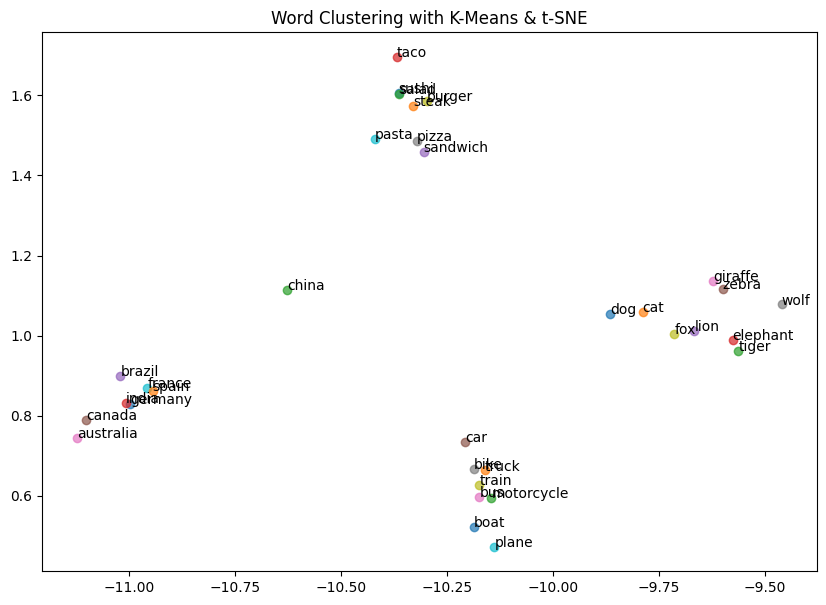

In [ ]:
plt.figure(figsize=(10, 7))
for i, word in enumerate(words):
    if word in word2vec_model:
        plt.scatter(reduced_vectors[i, 0], reduced_vectors[i, 1], label=word, alpha=0.7)
        plt.annotate(word, (reduced_vectors[i, 0], reduced_vectors[i, 1]))

plt.title("Word Clustering with K-Means & t-SNE")

# 🔴 **`nn.Embedding()`**

In [ ]:
import torch
import torch.nn as nn

## 🟠 Simple Example

In [ ]:
# a batch of 2 samples of 4 indices each
token_ids = torch.LongTensor([[1, 2, 4, 5], [4, 3, 2, 9]])
token_ids

# an Embedding module containing 10 tensors of size 3
embedding = nn.Embedding(10, 3, _freeze=True, _weight=torch.randn(10, 3))
embedding.weight

embedding(token_ids).shape

torch.Size([2, 4, 3])

## 🟠 `.from_pretrained()`

In [ ]:
# FloatTensor containing pretrained weights
embedding = nn.Embedding.from_pretrained(torch.HalfTensor(word2vec_model.vectors[:10000]))
embedding.weight.shape

torch.Size([10000, 300])

In [ ]:
# Get embeddings for index 1
token_ids = torch.LongTensor([1, 300, 500])
embedding(token_ids).shape

torch.Size([3, 300])